In [198]:
import warnings
from functools import wraps


def ignore_warnings(f):
    @wraps(f)
    def inner(*args, **kwargs):
        with warnings.catch_warnings(record=True) as w:
            warnings.simplefilter("ignore")
            response = f(*args, **kwargs)
        return response
    return inner

In [199]:
import sklearn
import math
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score as r2
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Normalizer
import matplotlib.pyplot as plt
import seaborn as sns
import stream as st

In [200]:
print(st.__version__)
values = (np.load("../BIO_Ml/GSE52588/GSE52588_beta_fn.npz"))["X"]
data = pd.read_csv("../BIO_Ml/GSE52588/GSE52588_samples.csv", delim_whitespace=True)

1.1


In [201]:
gene_names = pd.read_csv("../BIO_Ml/GSE52588/cpgs_annotations.csv")
cpg_names = pd.read_csv("../BIO_Ml/GSE52588/cpgs_annotations.csv")
cpg_names = cpg_names["ID_REF"]
cpg_names = cpg_names.replace(np.nan, "0")
x_cpg = pd.DataFrame(data=values, columns=cpg_names[:422802])
x_cpg["Age"] = data["age"]
x_cpg["Gene_Name"] = gene_names["UCSC_REFGENE_NAME"]

In [202]:
y = x_cpg["Age"]
#y = y.to_numpy()
X = x_cpg.drop(["Age", "Gene_Name"], axis=1)
#X = Normalizer().fit_transform(X)

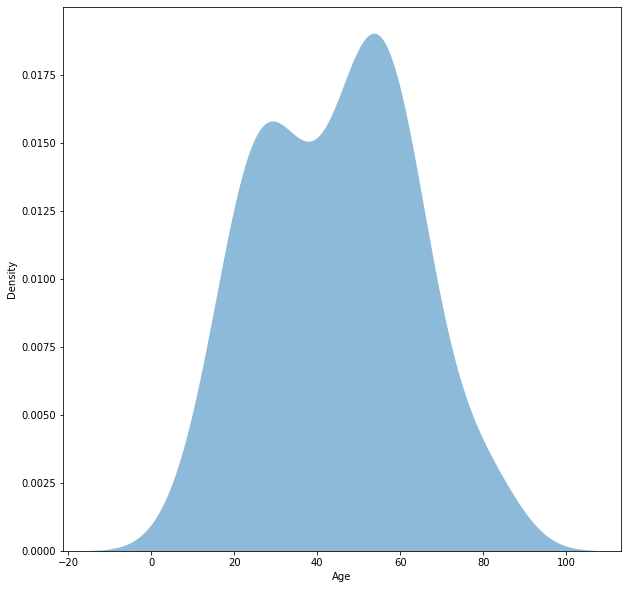

In [203]:
y = y[29:]
X = X[29:]
sns.kdeplot(data=y,
            fill=True,
            alpha=0.5,
            palette="crest",
            linewidth=0)
plt.rcParams["figure.figsize"] = (10,10)
plt.show()

In [204]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression

selector_k = SelectKBest(score_func=f_regression, k=50)
fit = selector_k.fit(X, y)
cols = selector_k.get_support(indices=True)
X = X.iloc[:, cols]
#X = fit.transform(X)

#X.to_csv('out.zip', index=False, compression="zip")

In [205]:
column_lables = pd.DataFrame(data=X.columns)
column_lables.to_csv("column_lables.csv", index=False, header=False)

In [206]:
# adata = st.read(file_name='out.csv',delimiter=',')
# st.add_cell_labels(adata,file_name='column_lables.csv')
#
# st.plot_visualization_2D(adata, method="umap", n_neighbors=10)
# st.seed_elastic_principal_graph(adata, n_clusters=10,use_vis=True)
# st.plot_dimension_reduction(adata,n_components=2,show_graph=True,show_text=False)
# st.plot_branches(adata,show_text=True)

In [207]:
feature = 12
ox = y
oy = X.iloc[:, feature]

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


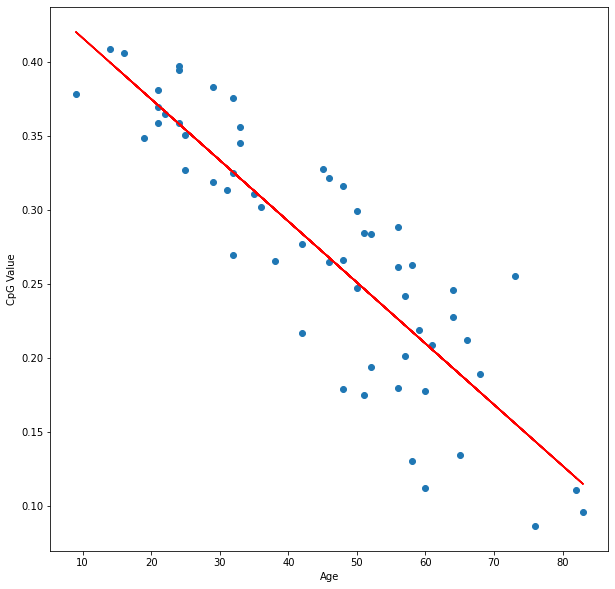

In [208]:
fig2 = plt.figure()
ax = plt.axes()
ax.plot(ox, oy, 'o')
m, b = np.polyfit(ox, oy, 1)

ax.plot(ox, m * ox + b, c="r")
ax.plot(ox, m * ox + b, c="r")

plt.rcParams["figure.figsize"] = (10,10)
plt.xlabel("Age")
plt.ylabel("CpG Value")

fig2.show()

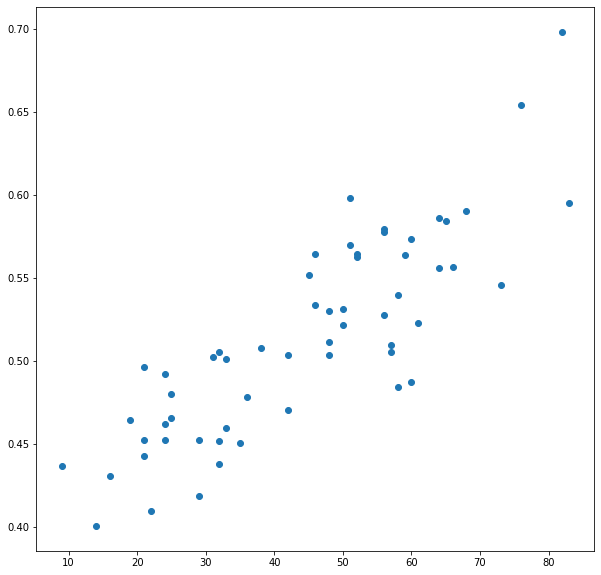

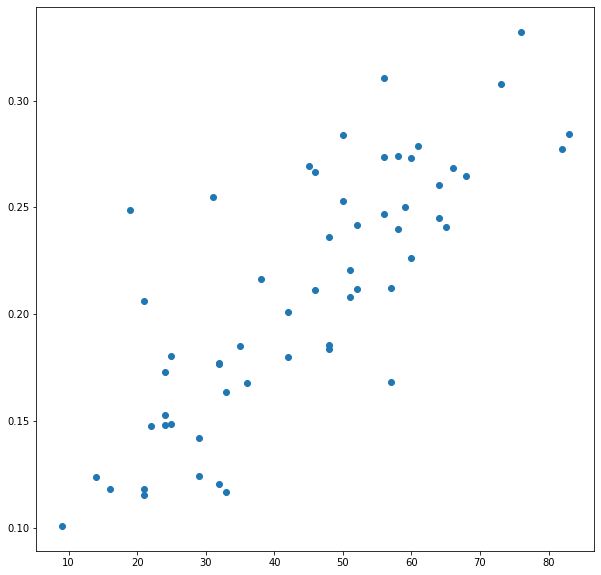

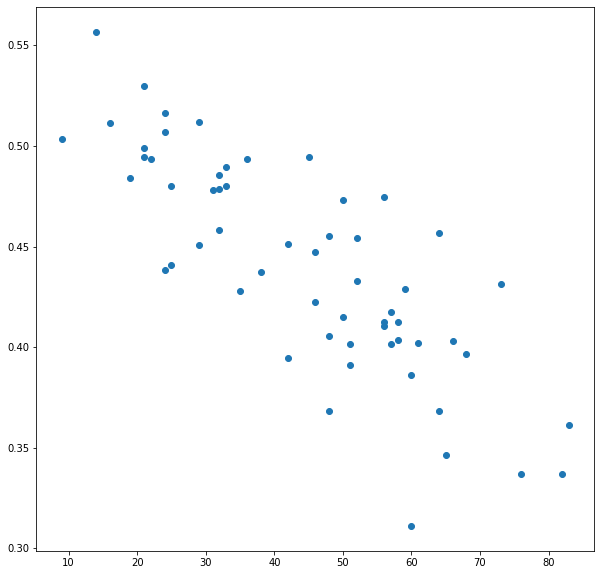

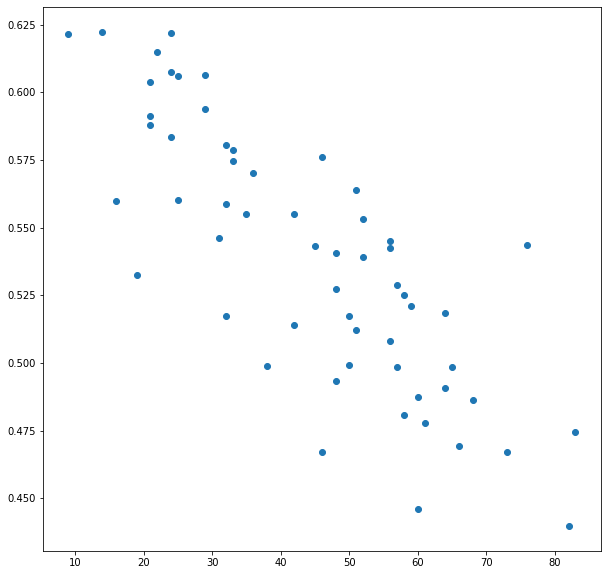

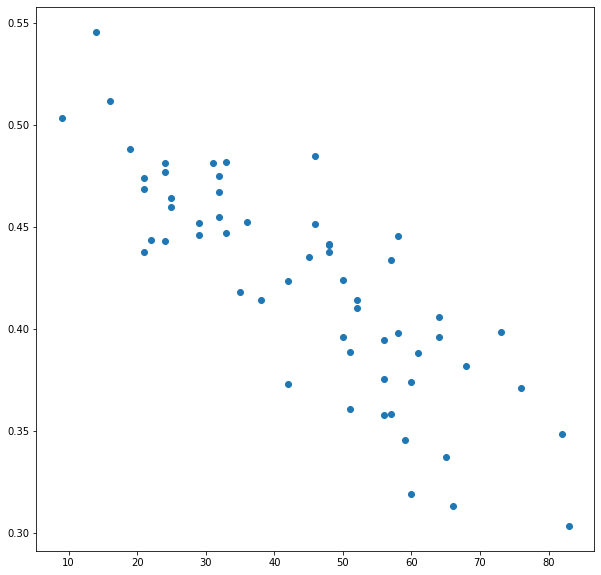

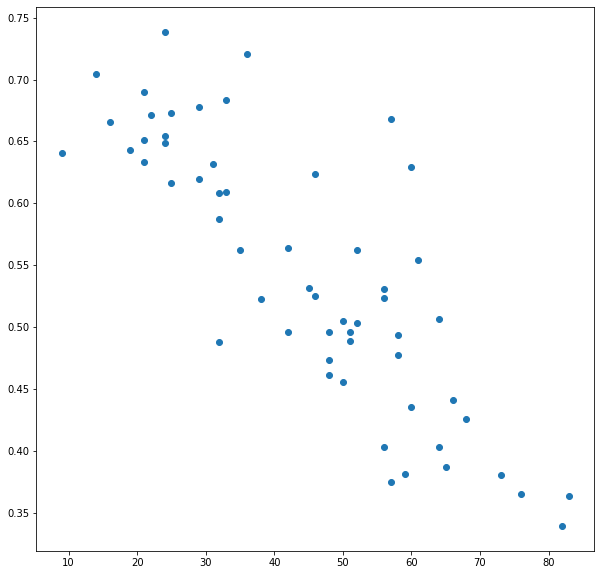

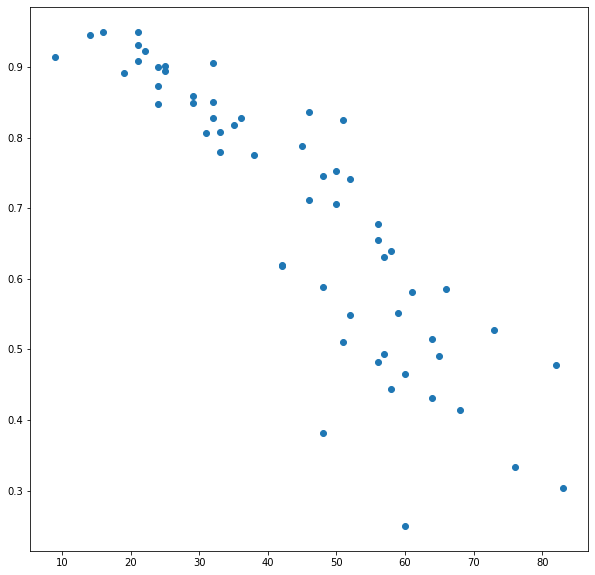

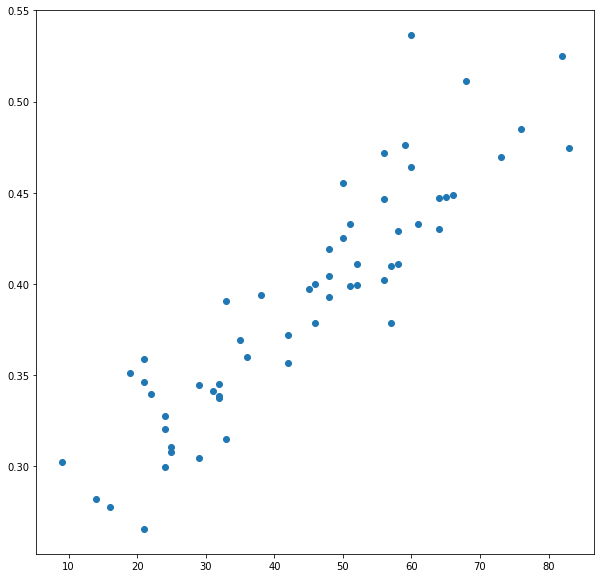

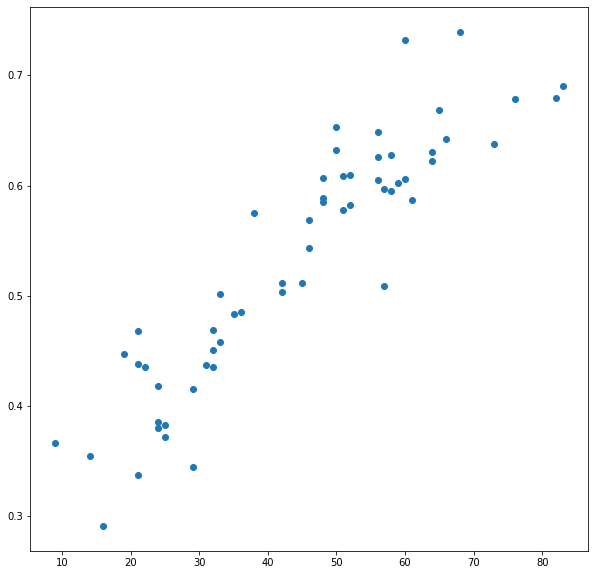

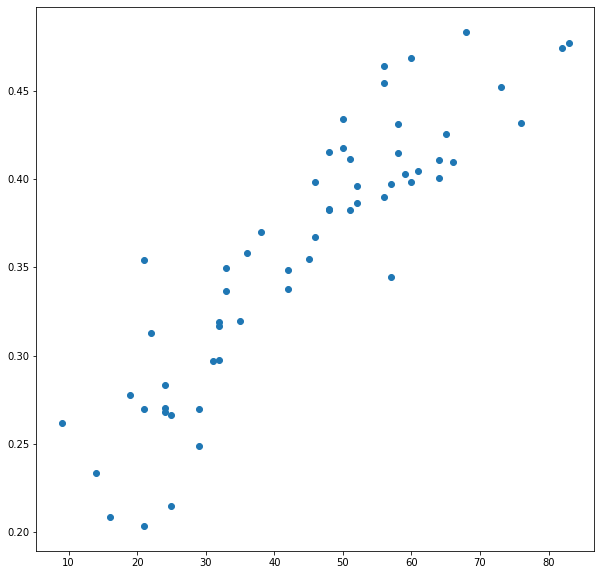

In [209]:
for i in range(10):
    oy = X.iloc[:, i]
    fig = plt.figure()
    ax = plt.axes()
    ax.scatter(ox, oy)
    fig.show

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


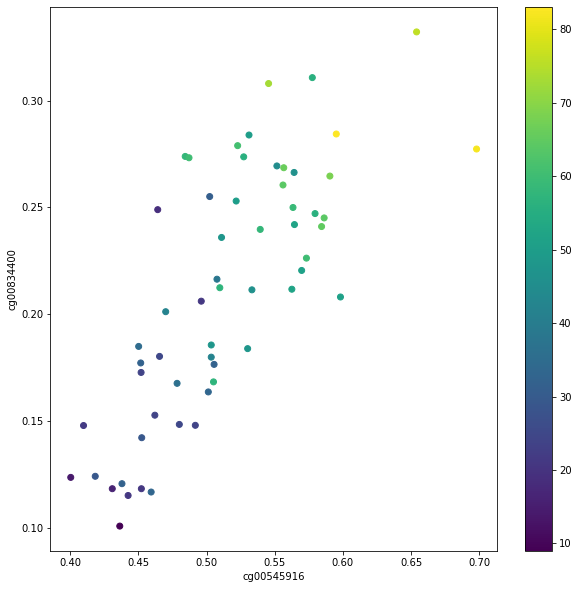

In [210]:
fig3 = plt.figure()
ax = plt.axes()
cpg1 = X.iloc[:, 0]
cpg2 = X.iloc[:, 1]

image = ax.scatter(cpg1, cpg2, c=y)
fig3.colorbar(image, ax=ax)
df_columns = X.columns

plt.rcParams["figure.figsize"] = (10,10)
plt.xlabel(df_columns[0])
plt.ylabel(df_columns[1])

fig3.show()

In [211]:
gene_names = pd.read_csv("../BIO_Ml/GSE52588/cpgs_annotations.csv")
gene_names = gene_names[["ID_REF", "UCSC_REFGENE_NAME"]]
gene_names = gene_names.replace(np.nan, "0")

important_cpgs = list(X.columns)
gene_names = gene_names[gene_names["ID_REF"].isin(important_cpgs)]
gene_names = gene_names.drop(gene_names[gene_names["UCSC_REFGENE_NAME"] == "0"].index).drop_duplicates()
gene_names = gene_names["UCSC_REFGENE_NAME"].drop_duplicates()

for i in range(len(gene_names)):
    gene_names.iloc[i] = set(gene_names.iloc[i].split(";"))

gene_names = gene_names.reset_index()
gene_names = gene_names["UCSC_REFGENE_NAME"]
# gene_names.to_excel("gene_names_CpG_based.xlsx", index = False)

In [212]:
from sklearn.model_selection import StratifiedKFold
from statistics import mean, stdev

#regressor = RandomForestRegressor(n_estimators=42, criterion="absolute_error", random_state=42)
regressor = SVR(kernel="poly", C=1.5)
skf = StratifiedKFold(n_splits=2, shuffle=True, random_state=1)
lst_accu_stratified = []

for train_index, test_index in skf.split(X, y):
    x_train_fold, x_test_fold = X.iloc[train_index], X.iloc[test_index]
    y_train_fold, y_test_fold = y.iloc[train_index], y.iloc[test_index]
    regressor.fit(x_train_fold, y_train_fold)
    lst_accu_stratified.append(regressor.score(x_test_fold, y_test_fold))

print('List of possible accuracy:', lst_accu_stratified)
print('\nMaximum Accuracy That can be obtained from this model is:',
      max(lst_accu_stratified) * 100, '%')
print('\nMinimum Accuracy:',
      min(lst_accu_stratified) * 100, '%')
print('\nOverall Accuracy:',
      mean(lst_accu_stratified) * 100, '%')
print('\nStandard Deviation is:', stdev(lst_accu_stratified))

List of possible accuracy: [0.9331946848446387, 0.9257490207711616]

Maximum Accuracy That can be obtained from this model is: 93.31946848446387 %

Minimum Accuracy: 92.57490207711616 %

Overall Accuracy: 92.94718528079002 %

Standard Deviation is: 0.005264879556792732


The least populated class in y has only 1 members, which is less than n_splits=2.


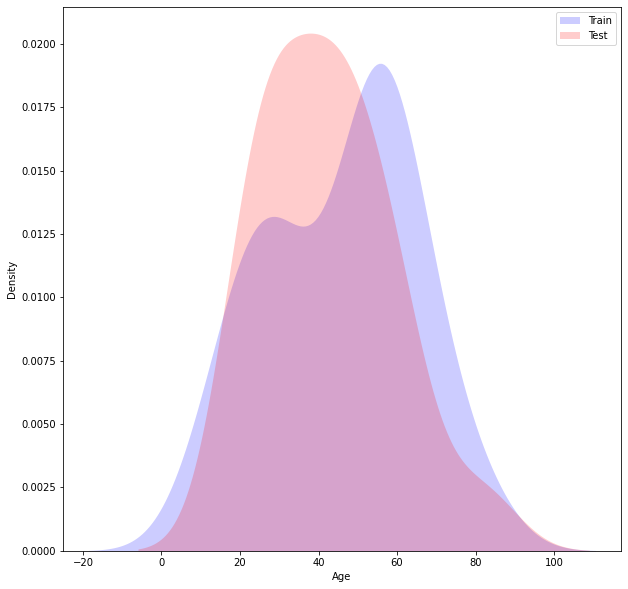

In [213]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
sns.kdeplot(y_train, color='b', fill=True, alpha=.2, linewidth=0)
sns.kdeplot(y_test, color="r", fill=True, alpha=.2, linewidth=0)
plt.rcParams["figure.figsize"] = (10,10)
plt.legend(["Train", "Test"])
plt.xlabel("Age")
plt.ylabel("Density")
plt.show()

In [214]:
regressor = SVR(kernel="poly", C=1.5)
model = regressor.fit(X_train, y_train)

In [215]:
y_pred = regressor.predict(X_test)
res = pd.DataFrame({"Actual": y_test, "Predicted": y_pred,
                    "AE": y_test - y_pred,
                    "SE": (y_test - y_pred) ** 2})
print("MAE: ", mean_absolute_error(y_test, y_pred), "MSE: ", mean_squared_error(y_test, y_pred))
print(res)


MAE:  2.979047472827326 MSE:  13.915653615424597
    Actual  Predicted        AE         SE
29      21  25.000471 -4.000471  16.003768
34      24  24.434711 -0.434711   0.188974
63      56  64.574527 -8.574527  73.522507
42      36  32.865687  3.134313   9.823918
73      46  45.689936  0.310064   0.096139
81      61  55.252372  5.747628  33.035227
66      64  61.941159  2.058841   4.238827
54      33  31.087260  1.912740   3.658576
75      45  41.152011  3.847989  14.807017
41      32  29.623607  2.376393   5.647244
77      82  74.569067  7.430933  55.218763
32      21  22.961901 -1.961901   3.849055
65      51  56.207978 -5.207978  27.123035
60      42  43.388375 -1.388375   1.927586
37      33  31.579640  1.420360   2.017421
46      24  22.807295  1.192705   1.422545
35      25  24.200438  0.799562   0.639300
33      42  45.784604 -3.784604  14.323228
70      56  56.818911 -0.818911   0.670615
48      48  51.177944 -3.177944  10.099326


  0%|          | 0/20 [00:00<?, ?it/s]

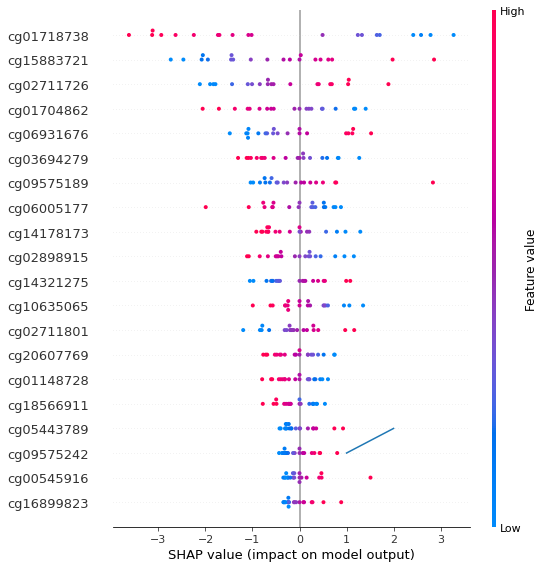

In [216]:
@ignore_warnings
def kernel_explain(X_train, X_test, regressor):
    import shap
    X_train_summary = shap.kmeans(X_train, 10)
    ex = shap.KernelExplainer(regressor.predict, X_train_summary)
    shap_values = ex.shap_values(X_test)
    plt.plot([1, 2], [2, 3])
    shap.summary_plot(shap_values, X_test)

kernel_explain(X_train, X_test, regressor)

In [217]:
y_test = y_test.to_numpy()

1.0.1


Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


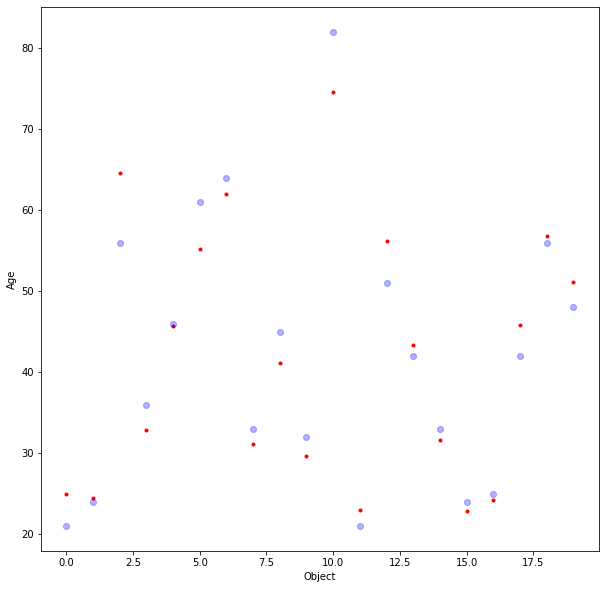

In [218]:
fig4 = plt.figure()
ax = plt.axes()

plt.plot(y_pred, ".", c="r")
plt.plot(y_test, "o", c="b", alpha=0.3)
plt.xlabel("Object")
plt.ylabel("Age")
plt.rcParams["figure.figsize"] = (10,10)

fig4.show()
print(sklearn.__version__)